# Heart Failure Prediction

Trabalho final da disciplina de Engenharia de Sistemas de Software Inteligentes do curso de Engenharia de Software da Pontifícia Universidade Católica do Rio de Janeiro (PUC-Rio).

## Descrição do Projeto

Este projeto é modelo de Machine Learning para predição de insuficiência cardíaca. O objetivo é permitir que os usuários enviem dados clínicos e recebam de volta a predição correspondente.

### Atenção
Este projeto é apenas um modelo desenvolvido para estudos e não deve ser usado para diagnósticos médicos reais.
Sempre consulte um profissional de saúde qualificado para questões médicas.

### Etapa 1: Importação das bibliotecas necessárias

In [24]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
import pickle
import os

### Etapa 2: Carga do Dataset

In [ ]:
# url = "./heart.csv"
url = "https://raw.githubusercontent.com/robertheory/heart-failure-prediction/refs/heads/master/server/ml/heart.csv"

dataset = pd.read_csv(url)

# Codifica variáveis categóricas
dataset['Sex'] = dataset['Sex'].map({'M': 1, 'F': 0})
dataset['ExerciseAngina'] = dataset['ExerciseAngina'].map({'Y': 1, 'N': 0})

# One-hot encoding para as demais
dataset = pd.get_dummies(dataset, columns=['ChestPainType', 'RestingECG', 'ST_Slope'])

# Passa os dados para o formato float
dataset = dataset.astype(float)

# Exibe as primeiras linhas do dataset
dataset.head()

,Age,Sex,RestingBP,Cholesterol,FastingBS,MaxHR,ExerciseAngina,Oldpeak,HeartDisease,ChestPainType_ASY,ChestPainType_ATA,ChestPainType_NAP,ChestPainType_TA,RestingECG_LVH,RestingECG_Normal,RestingECG_ST,ST_Slope_Down,ST_Slope_Flat,ST_Slope_Up
0,40.0,1.0,140.0,289.0,0.0,172.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,49.0,0.0,160.0,180.0,0.0,156.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
2,37.0,1.0,130.0,283.0,0.0,98.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,48.0,0.0,138.0,214.0,0.0,108.0,1.0,1.5,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
4,54.0,1.0,150.0,195.0,0.0,122.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0


### Etapa 3: Separação em Conjuntos (Holdout)

In [14]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação dos dados em treino e teste
X = dataset.drop('HeartDisease', axis=1)  # Features
y = dataset['HeartDisease']  # Target
X_train, X_test, y_train, y_test = train_test_split(X, y,
  test_size=test_size, random_state=seed, stratify=y)  # estratificação para manter a proporção das classes

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10  # número de partições para validação cruzada

# Ajusta o número de partições para não exceder o número mínimo de amostras por classe
min_samples_per_class = np.min(np.bincount(y_train))
num_particoes = min(num_particoes, min_samples_per_class)
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

### Etapa 4: Criação e avaliação de modelos: linha base

KNN: 0.709719 (0.052887)
CART: 0.799741 (0.027851)
NB: 0.852851 (0.049713)
SVM: 0.728971 (0.033231)


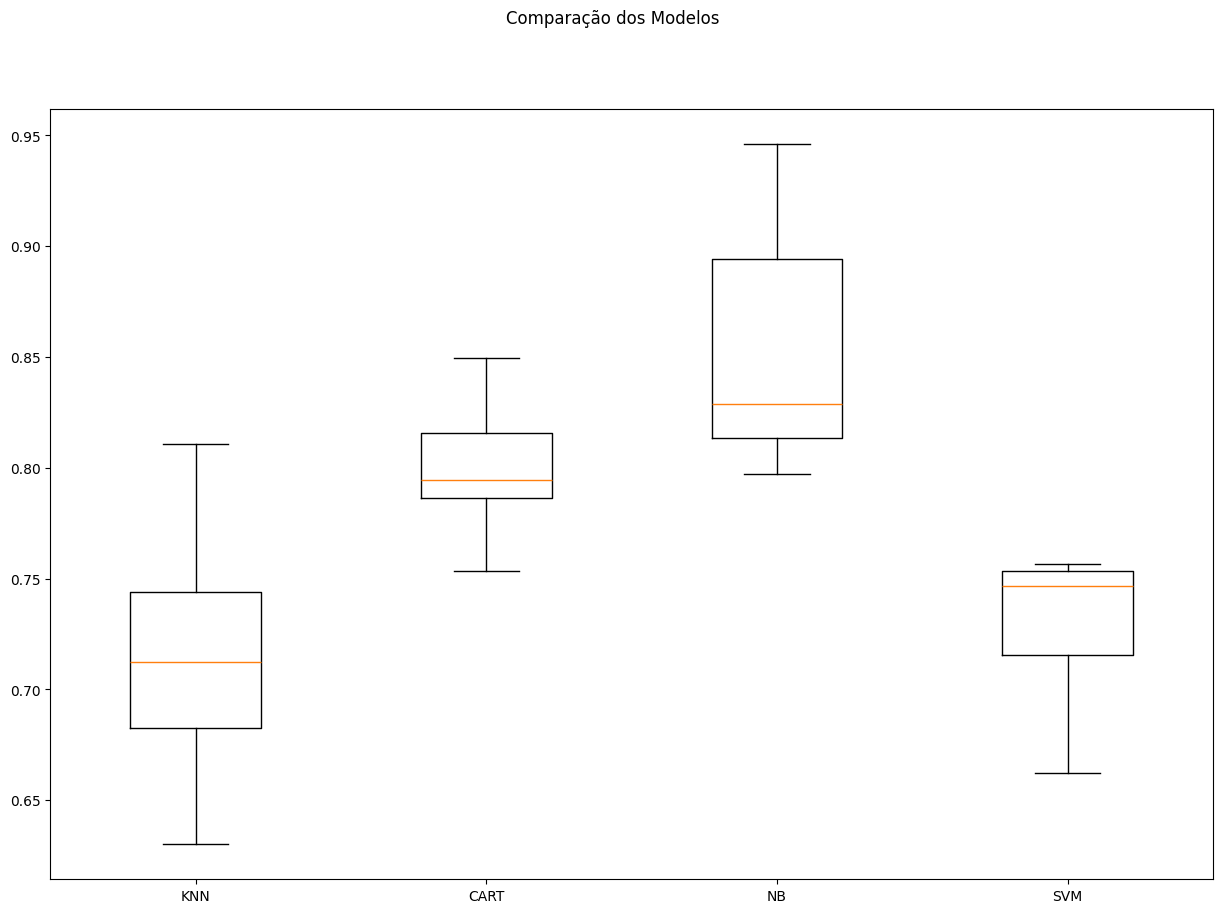

In [15]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []

# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Etapa 5: Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.710 (0.053)
CART-orig: 0.800 (0.028)
NB-orig: 0.853 (0.050)
SVM-orig: 0.729 (0.033)
KNN-padr: 0.857 (0.037)
CART-padr: 0.792 (0.030)
NB-padr: 0.853 (0.050)
SVM-padr: 0.862 (0.037)
KNN-norm: 0.852 (0.041)
CART-norm: 0.792 (0.037)
NB-norm: 0.853 (0.050)
SVM-norm: 0.862 (0.039)


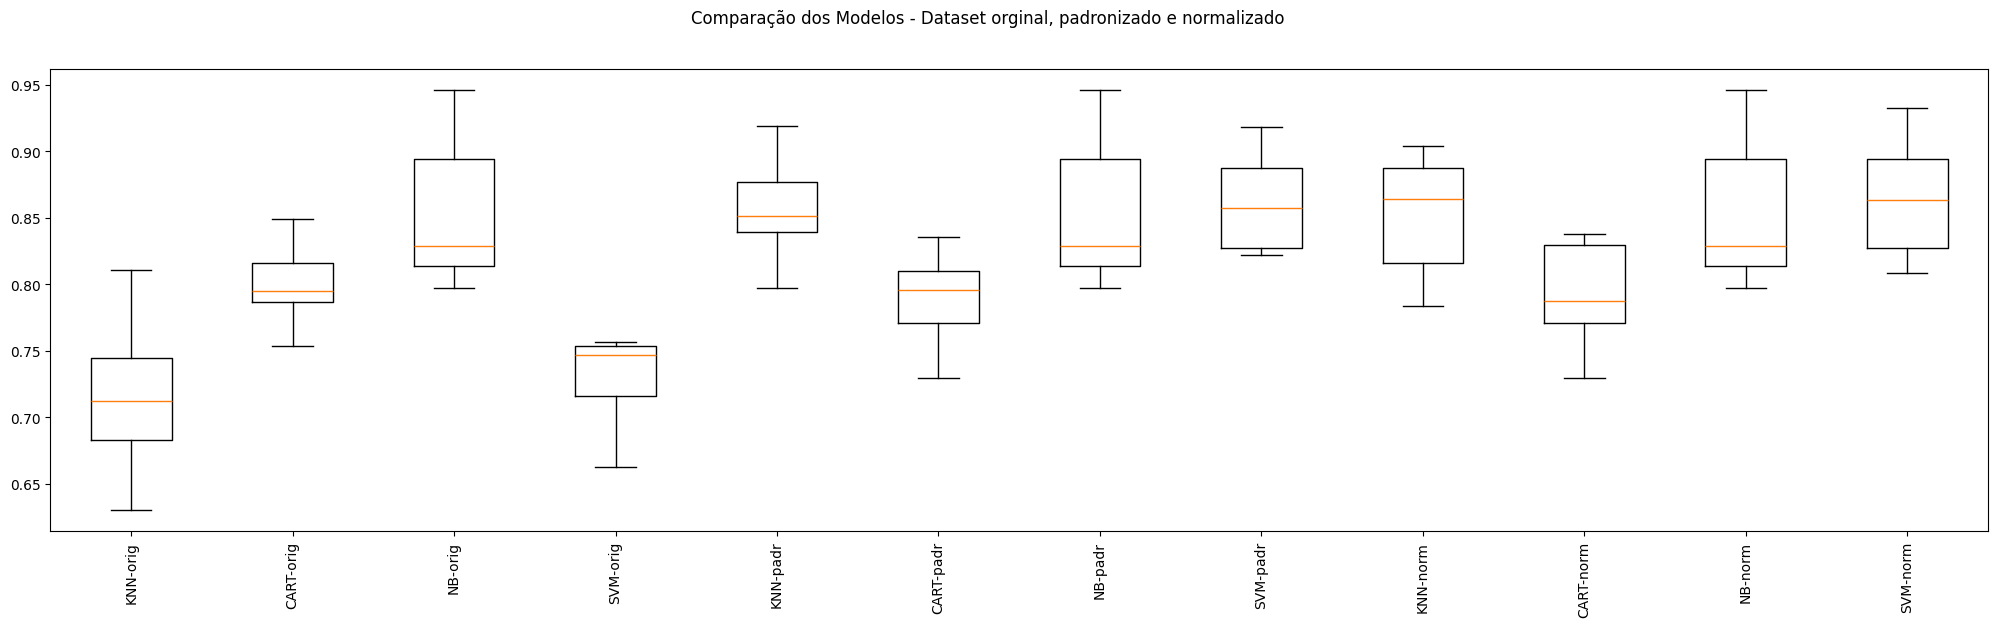

In [16]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []

# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Etapa 6: Otimização dos hiperparâmetros para Naive Bayes

In [17]:
np.random.seed(7) # definindo uma semente global para este bloco

param_grid = {
    'var_smoothing': np.logspace(0, -9, num=100)
}

naive_bayes = GaussianNB()

grid_search = GridSearchCV(estimator=naive_bayes, param_grid=param_grid, scoring=scoring, cv=kfold, n_jobs=-1)
grid_result = grid_search.fit(X_train, y_train)

# Exibindo os melhores parâmetros e o melhor resultado
print("Melhores parâmetros: ", grid_result.best_params_)
print("Melhor resultado: %.3f (%.3f)" % (grid_result.best_score_, grid_result.cv_results_['std_test_score'][grid_result.best_index_]))


Melhores parâmetros:  {'var_smoothing': np.float64(8.111308307896873e-06)}
Melhor resultado: 0.868 (0.036)


### Etapa 7: Finalização do Modelo

In [18]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = GaussianNB(var_smoothing=grid_result.best_params_['var_smoothing']) # criação do modelo com os melhores parâmetros
model.fit(rescaledX, y_train) # treinamento do modelo

# Avaliação do modelo com o conjunto de testes
test_rescaledX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(test_rescaledX) # previsões com o modelo treinado
print(accuracy_score(y_test, predictions))


0.8206521739130435


In [19]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

,priors,None
,var_smoothing,np.float64(8....307896873e-06)


### Etapa 8: Simulando a aplicação do modelo em dados não vistos

In [20]:
# Novos dados - não sabemos a classe!

# 2 entradas de teste: 1 positivas (Com Doença Cardíaca), 1 negativas (Sem Doença Cardíaca)
# 1 - Negativa (Sem Doença Cardíaca)
# 2 - Positiva (Com Doença Cardíaca)
data = {
    'Age': [45, 60],
    'Sex': [1, 0],
    'RestingBP': [80, 85],
    'Cholesterol': [1, 1],
    'FastingBS': [0, 0],
    'MaxHR': [100, 110],
    'ExerciseAngina': [0, 1],
    'Oldpeak': [1.5, 2.0],
    'ChestPainType_ASY': [0, 1],
    'ChestPainType_ATA': [1, 0],
    'ChestPainType_NAP': [0, 0],
    'ChestPainType_TA': [0, 0],
    'RestingECG_LVH': [0, 1],
    'RestingECG_Normal': [1, 0],
    'RestingECG_ST': [0, 0],
    'ST_Slope_Down': [0, 1],
    'ST_Slope_Flat': [1, 0],
    'ST_Slope_Up': [0, 0]
}

atributos = ['Age', 'Sex', 'RestingBP', 'Cholesterol', 'FastingBS', 'MaxHR', 'ExerciseAngina', 'Oldpeak', 'ChestPainType_ASY', 'ChestPainType_ATA', 'ChestPainType_NAP', 'ChestPainType_TA', 'RestingECG_LVH', 'RestingECG_Normal', 'RestingECG_ST', 'ST_Slope_Down', 'ST_Slope_Flat', 'ST_Slope_Up']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values.astype(np.float64)  # Convertendo o DataFrame para um array NumPy de tipo float64
# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(array_entrada)
print(rescaledEntradaX)

[[-0.90277524  0.51595242 -2.83162145 -1.80928769 -0.55134134 -1.44654163
  -0.8235563   0.57471149 -1.08413811  2.07517671 -0.53283777 -0.22967867
  -0.50747832  0.81427482 -0.49044933 -0.27144836  0.99782372 -0.86905588]
 [ 0.68831845 -1.93816322 -2.56141059 -1.80928769 -0.55134134 -1.05355971
   1.21424608  1.04375945  0.9223917  -0.48188667 -0.53283777 -0.22967867
   1.97052752 -1.22808661 -0.49044933  3.68394199 -1.00218103 -0.86905588]]


In [21]:
# Predição de classes dos dados de entrada
description = {
  0: "Negativo",
  1: "Positivo"
}

saidas = model.predict(rescaledEntradaX)

print('Doença Cardíaca: ')
print([description[s] for s in saidas])

Doença Cardíaca: 
['Negativo', 'Positivo']


### Etapa 9: Exportando o modelo para o formato PKL

In [22]:
# Salvar o modelo no arquivo
filename = 'heart_disease_model.pkl'
pickle.dump(model, open(filename, 'wb'))

# Sakvar o scaler no arquivo
scaler_filename = 'heart_disease_scaler.pkl'
pickle.dump(scaler, open(scaler_filename, 'wb'))

print(f"Modelo exportado para '{filename}'")

Modelo exportado para 'heart_disease_model.pkl'


### Análise dos Resultados

Inicialmente, foi realizada um teste com 4 algoritmos: 

- KNN: K-Nearest Neighbors (K Vizinhos Mais Próximos)
- Decision Tree: Árvore de Decisão
- Naive Bayes: Classificador Naive Bayes
- SVM: Máquinas de Vetores de Suporte

Os resultados mostraram que o modelo Naive Bayes teve o melhor desempenho, com uma acurácia de 0.85, sendo assim escolhido como modelo base.

Durante a etapa de padronização e normalização dos dados, tivemos poucas diferenças significativas nas métricas de desempenho entre os modelos, mas o Naive Bayes continuou a se destacar.

Foi na etapa de otimização dos hiper parâmetros que conseguimos melhorar um pouco mais o desempenho do modelo Naive Bayes, ajustando o parâmetro `var_smoothing`, o que resultou em uma leve melhoria na acurácia, agora alcançando 0.86.

O modelo final, treinado com todo o conjunto de dados e utilizando os melhores hiperparâmetros encontrados, foi capaz de generalizar bem para novos exemplos, conforme demonstrado na etapa de simulação com dados não vistos. A exportação do modelo e do scaler garante a reprodutibilidade e a possibilidade de uso em aplicações futuras.

**Pontos de atenção:**
- O dataset utilizado é relativamente pequeno e pode não representar toda a diversidade de casos reais.
- O modelo não deve ser utilizado para diagnósticos médicos reais, servindo apenas como ferramenta de estudo.
- Novos testes com outros algoritmos podem ser explorados para aprimorar ainda mais os resultados.

### Conclusão

O trabalho demonstrou, de forma prática, o processo completo de desenvolvimento de um modelo de machine learning para predição de insuficiência cardíaca: desde a avaliação de diferentes algoritmos, otimização de hiperparâmetros, até a validação e exportação do modelo final. Os resultados obtidos reforçam a importância do pré-processamento e da escolha adequada dos algoritmos para problemas de classificação em saúde.

Destaca-se que, apesar dos bons resultados, o uso de modelos preditivos em saúde deve ser sempre acompanhado de validação clínica e supervisão de profissionais qualificados.

### Exportando diferentes modelos para teste

In [25]:
# Garante que a pasta 'models' existe
os.makedirs('models', exist_ok=True)

# Lista dos modelos a serem treinados e exportados
modelos = [
  ('knn', KNeighborsClassifier()),
  ('cart', DecisionTreeClassifier()),
  ('nb', GaussianNB(var_smoothing=grid_result.best_params_['var_smoothing'])),
  ('svm', SVC(probability=True))
]

# Treina e exporta cada modelo usando o dataset completo e entrada padronizada
for nome, modelo in modelos:
  modelo.fit(rescaledX, y)
  # Exporta o modelo
  with open(f'./models/heart_disease_model_{nome}.pkl', 'wb') as f:
    pickle.dump(modelo, f)

print("Todos os modelos foram treinados e exportados para a pasta 'models'.")

Todos os modelos foram treinados e exportados para a pasta 'models'.
